#### Import packages

In [1]:
from IPython.display import clear_output
from IPython.display import display, Math
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import plot_tools
import arviz as az
from scipy.interpolate import interp1d
import scipy.stats as stats
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import nct
import numpy as np
import warnings
warnings.filterwarnings("ignore")
# az.style.use("arviz-grayscale")
clear_output()

#### Subtask 2.a)

1. likelihood follow a normal distribution, $p(y_1|\mu, \sigma) = \frac{1}{\sqrt{2\pi} \sigma}\exp(-\frac{1}{2\sigma^2}(y-\mu)^2)$  
The likelihood describe the car windshields hardness value $y_1$ with unknown mean and variance $\mu$ and $\sigma$ as parameter. According to the description, we are formulating a likelihood in a normal distribution shape.
     
2. prior: $p(\mu, \sigma) \propto (\sigma) ^{-1}$  
In this case, the prior, representing the initial knowledge / believe about the data, is a non-informative prior, is propotional to $\sigma ^{-1}$
  
3. the resulting posterior $p(\mu, \sigma^2|y_1)$  

    The prosteriror distribution is proportional to the multiplication of the likelihood and prior. $p(\mu, \sigma^2|y_1) \propto p(y_1|\mu, \sigma^2) \cdot p(\mu, \sigma^2)$. According to the text book 3.2, we have 
      
    $p(\mu, \sigma^2|y_1) \propto \sigma^{-n-2} \exp (-\frac{1}{2\sigma^2}[(n-1)s^2 + n(\bar{y}-\mu)^2])$  
      
    where $s^2 = \frac{1}{n-1} \sum_{i=1}^{n}(y_i-\bar{y})^2$ is the sample variance of the $y_i$'s. The sufficient statistics are $\bar{y}$ and $s^2$


#### Subtask 2.b)

In [2]:
data = pd.read_csv('windshield1.csv')
df_list = list(data.iloc[:, 0])
first_position = float(data.columns[0])
df_list.insert(0, first_position)
df = pd.DataFrame(df_list)
hardness_values = df.iloc[:, 0]

def likelihood(mu, sigma):
    return norm.pdf(hardness_values, loc=mu, scale=sigma)

def prior(mu, sigma):
    return 1 / sigma

def posterior(mu, sigma):
    return likelihood(mu, sigma).prod() * prior(mu, sigma)

# Grids for μ and σ, refering LD50 case
mu_values = np.linspace(11, 19, 1000)  
sigma_values = np.linspace(1, 20, 1000) 

# calculate the unnormalized posterior for each combination of μ and σ
posterior_values = np.zeros((len(mu_values), len(sigma_values)))
for i, mu in enumerate(mu_values):
    for j, sigma in enumerate(sigma_values):
        posterior_values[i, j] = posterior(mu, sigma)

# normalize the posterior
posterior_values /= posterior_values.sum()

# point estimate E(μ|y)
mu_posterior = np.sum(mu_values * posterior_values.sum(axis=1))
sigma_posterior = np.sum(sigma_values * posterior_values.sum(axis=0))

# calculate the posterior 95%-interval (credible interval)
cdf = np.cumsum(np.cumsum(posterior_values, axis=1), axis=0)
lower_quantile = 0.025
upper_quantile = 0.975
mu_lower = np.percentile(mu_values, 100 * lower_quantile)
mu_upper = np.percentile(mu_values, 100 * upper_quantile)

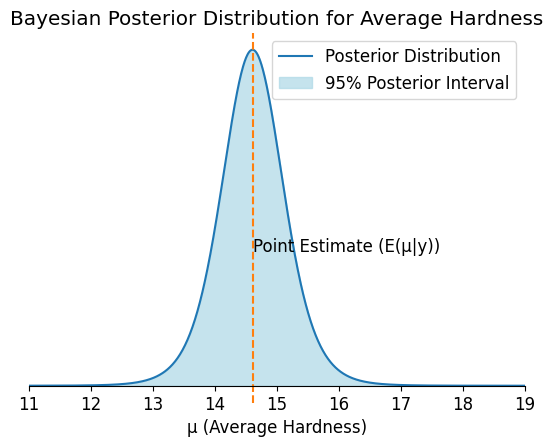

Point Estimate (E(μ|y)): 14.61
95% Posterior Interval: [11.20, 18.80]


In [3]:
# Plot the posterior distribution
plt.rc('font', size=12) #set the plot
plt.plot(mu_values, posterior_values.sum(axis=1), label='Posterior Distribution')
plot_tools.modify_axes.only_x() # show only x-axis
plt.axvline(mu_posterior, color='C1', linestyle='--')
plt.fill_between(mu_values, 0, posterior_values.sum(axis=1), where=(mu_values >= mu_lower) & (mu_values <= mu_upper),
                 color='lightblue', alpha=0.7, label='95% Posterior Interval')

plt.annotate(
    'Point Estimate (E(μ|y))',
    (mu_posterior, posterior_values.sum(axis=1).max() * 0.4), 
    ha='left'  # horizontal alignment
)

plt.xlabel('μ (Average Hardness)')
plt.title('Bayesian Posterior Distribution for Average Hardness')
plt.legend()
plt.autoscale(axis='x', tight=True) # scale x-axis tightly to the data.
plt.show()

# Print the results
print(f"Point Estimate (E(μ|y)): {mu_posterior:.2f}")
print(f"95% Posterior Interval: [{mu_lower:.2f}, {mu_upper:.2f}]")

In [4]:
interpretation = """
The point estimate value represents the most likely estimate of μ given the data and noninformative prior knowledge.
The posterior distribution density is similar to a normal distribution centered around 14.61
The mean of the unknown μ distribution based on the calculation is 14.61. This means, the most likely mean μ of car windshields distribution is around 14.61. 
While the 95% posterior interval for μ tells that we have a 95% level of confidence in the range [11.20, 18.80] as the likely values for μ.
"""
print("Interpretation:", interpretation)

Interpretation: 
The point estimate value represents the most likely estimate of μ given the data and noninformative prior knowledge.
The posterior distribution density is similar to a normal distribution centered around 14.61
The mean of the unknown μ distribution based on the calculation is 14.61. This means, the most likely mean μ of car windshields distribution is around 14.61. 
While the 95% posterior interval for μ tells that we have a 95% level of confidence in the range [11.20, 18.80] as the likely values for μ.



#### Subtask 2.c)

Given the predictive posterior equation: $$ P(y^* | y) = \int P(y^* | \mu, \sigma, y) \cdot P(\mu, \sigma | y) \, d\mu \, d\sigma $$ and the expectation of the predictive posterior equation: 
$$
E[y^* | y] = \int \left(\int y^* \cdot P(y^* | \mu, \sigma, y) \, dy^*\right) \cdot P(\mu, \sigma | y) \, d\mu \, d\sigma
$$
$$\because (\mu, \sigma) = \int (y * P(y|\mu, \sigma)) dy
 \therefore E[y^* | y] = \int (\mu,\sigma)^*\cdot P((\mu, \sigma|y))dy
$$
As we can tell, only the parameter $\mu$ matters for this question because the mean of this distribution is $\mu$, so there is no need to consider $\sigma$



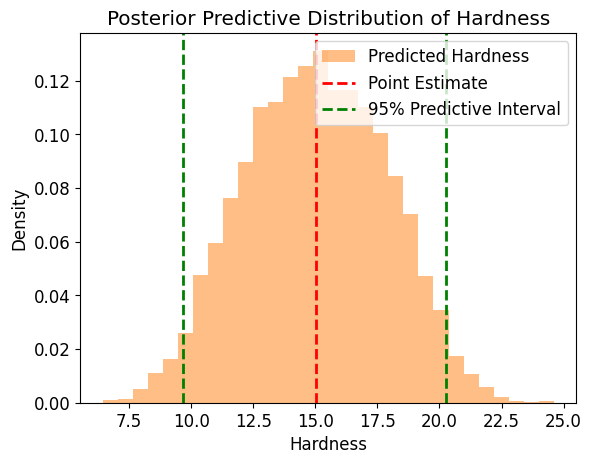

The point estimate is 15.018 
The predictive 95%-interval is ['9.673', '20.269']

Based on the sampling (to estimate expectations) result, the point estimate is15.018; 
we are 95% confident that the true hardness of the next windshield will fall within the range of [9.673] to [20.269]. 
This interval represents the possible hardness values for the next windshield."
The density plot shape is roughly normally distributed, indicate the conjugacy of the prior based on the normal distributied likelihood.
However, in this case, the hardness can be negative due to the normal distribution. So, we probably need data transformation to make the value non-negative.



In [5]:
# sample from the posterior predictive distribution
num_samples = 10000 
posterior_predictive_samples = []
for _ in range(num_samples):
    sample_idx = np.random.choice(len(mu_values))
    mu_sample = mu_values[sample_idx]
    sample_idx = np.random.choice(len(sigma_values))
    sigma_sample = sigma_posterior
    predicted_hardness = np.random.normal(mu_sample, sigma_sample)
    posterior_predictive_samples.append(predicted_hardness)
point_estimate = np.mean(posterior_predictive_samples)
# posterior predictive 95%-interval
lower_quantile = 0.025
upper_quantile = 0.975
lower_bound = np.percentile(posterior_predictive_samples, 100 * lower_quantile)
upper_bound = np.percentile(posterior_predictive_samples, 100 * upper_quantile)

plt.rc('font', size=12) #set the plot
plt.hist(posterior_predictive_samples, bins=30, density=True, alpha=0.5, color='C1', label='Predicted Hardness')
plt.xlabel('Hardness')
plt.ylabel('Density')
plt.axvline(point_estimate, color='red', linestyle='dashed', linewidth=2, label='Point Estimate')
plt.axvline(lower_bound, color='green', linestyle='dashed', linewidth=2, label='95% Predictive Interval')
plt.axvline(upper_bound, color='green', linestyle='dashed', linewidth=2)
plt.legend()
plt.title('Posterior Predictive Distribution of Hardness')
plt.grid(False)
plt.show()
formatted_point_estimate = f"{point_estimate:.3f}"
formatted_lower_bound = f"{lower_bound:.3f}"
formatted_upper_bound = f"{upper_bound:.3f}"
print('The point estimate is', formatted_point_estimate, '\nThe predictive 95%-interval is', [formatted_lower_bound, formatted_upper_bound])
interpretation2 = f"""
Based on the sampling (to estimate expectations) result, the point estimate is{formatted_point_estimate}; 
we are 95% confident that the true hardness of the next windshield will fall within the range of [{formatted_lower_bound}] to [{formatted_upper_bound}]. 
This interval represents the possible hardness values for the next windshield."
The density plot shape is roughly normally distributed, indicate the conjugacy of the prior based on the normal distributied likelihood.
However, in this case, the hardness can be negative due to the normal distribution. So, we probably need data transformation to make the value non-negative.
"""
print(interpretation2)


### Inference for the difference between proportions


#### Subtask 3.a)

 formulate this as a single model for the difference in proportions

1. likelihood $p(d_0|p_0)$ as a function of $p_0$ for control group: 
$p(d_0|p_0) = \text{Binomial} (d_0|n_0, p_0)=\binom{n_0}{d_0}\cdot p_0^{d_0}(1-p_0)^{n_0-d_0}$  
where on the left side  
   * this probability distribution models the number of deat ($d_0$) in a fixed number of population ($n_0$), each with a probability of success represented by $p_0$.
     
   likelihood $p(d_1|p_1)$ as a function of $p_1$ for treatment group: 
   $p(d_1|p_1) = \text{Binomial} (d_1|n_1, p_1)=\binom{n_1}{d_1}\cdot p_0^{d_1}(1-p_1)^{n_1-d_1}$  
   where on the left side  
      * this probability distribution models the number of death ($d_1$) in a fixed number of population ($n_1$), each with a probability of success represented by $p_1$.  
    
2. prior for control group $p(p_0) =  p(p_0| 1, 1)  \propto \theta^{\alpha-1} \cdot (1 - \theta)^{\beta-1} = Beta(1, 1)$  
   * This is Beta distribution with parameters $\alpha=1$ and $\beta=1$ as a non-informative prior
  
   prior for treatment group $p(p_1) =  p(p_1| 1, 1)  \propto \theta^{\alpha-1} \cdot (1 - \theta)^{\beta-1} = Beta(1, 1)$  
      * This is Beta distribution with parameters $\alpha=1$ and $\beta=1$ as a non-informative prior
  
3. the resulting posterior $p(p_0|d_0)$ for control group  
   $$\text{Posterior}(p_0 | \text{Data}) \propto \text{Likelihood}(p_0 | \text{Data}) \cdot \text{Prior}(p_0)$$

   $\because$ the beta prior distribution conjugate the biniomial sample distribution, the posterior is also a beta function.   
   After normalizing the unnormalized posterior distribution to make it a proper probability distribution,  
   $\therefore p(p_0|d_0, n_0, M) \propto p_0^{d_0} \cdot (1 - p_0)^{n_0-d_0} \cdot p_0^{\alpha-1} \cdot (1 - p_0)^{\beta-1} = p(p_0| d_0 + 1, n_0 - d_0+ 1)$  

   the resulting posterior $p(p_1|d_1)$ for treatment group  
   $$\text{Posterior}(p_1 | \text{Data}) \propto \text{Likelihood}(p_1 | \text{Data}) \cdot \text{Prior}(p_1)$$
   After normalizing the unnormalized posterior distribution to make it a proper probability distribution,  
   $ p(p_1|d_1, n_1, M) \propto p_1^{d_1} \cdot (1 - p_1)^{n_1-d_1} \cdot p_1^{\alpha-1} \cdot (1 - p_1)^{\beta-1} = p(p_1| d_1 + 1, n_1 - d_1+ 1)$  


#### Subtask 3.b)

Point Estimate (Mean Odds Ratio): 0.569
Posterior 95% Credible Interval: [0.315 0.921]


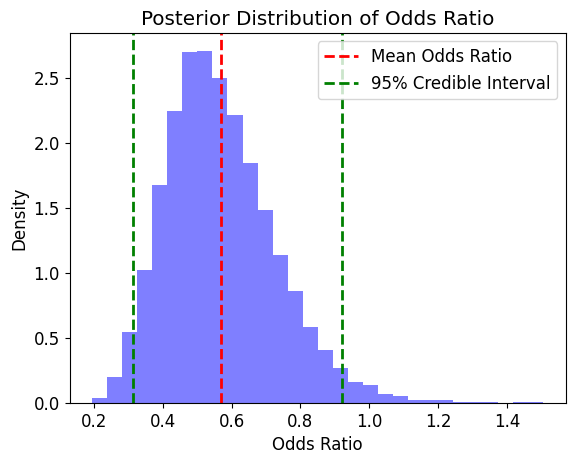

In [6]:
def posterior_for_or(alpha0, beta0, alpha1, beta1):
    n0 = 674
    n1 = 680
    deaths_control = 39
    deaths_treatment = 22

    # sample from the posterior distributions of p0 and p1 groups using Beta distribution
    posterior_samples_p0 = stats.beta.rvs(alpha0 + deaths_control, beta0 + n0 - deaths_control, size=10000)
    posterior_samples_p1 = stats.beta.rvs(alpha1 + deaths_treatment, beta1 + n1 - deaths_treatment, size=10000)

    # odds ratio for each sample
    odds_ratio_samples = (posterior_samples_p1 / (1 - posterior_samples_p1)) / (posterior_samples_p0 / (1 - posterior_samples_p0))
    mean_odds_ratio = np.mean(odds_ratio_samples) # point estimate (mean) of the odds ratio
    credible_interval = np.percentile(odds_ratio_samples, [2.5, 97.5]) # 95% credible interval for the odds ratio
    return odds_ratio_samples, mean_odds_ratio, credible_interval

odds_ratio_samples, mean_odds_ratio, credible_interval = posterior_for_or(1, 1, 1, 1)
rounded_credible_interval = np.round(credible_interval, 3)

print("Point Estimate (Mean Odds Ratio):", f"{mean_odds_ratio:.3f}")
print("Posterior 95% Credible Interval:", rounded_credible_interval)
plt.rc('font', size=12) #set the plot
plt.hist(odds_ratio_samples, bins=30, density=True, alpha=0.5, color='b')
plt.xlabel('Odds Ratio')
plt.ylabel('Density')
plt.title('Posterior Distribution of Odds Ratio')
plt.axvline(mean_odds_ratio, color='red', linestyle='dashed', linewidth=2, label='Mean Odds Ratio')
plt.axvline(credible_interval[0], color='green', linestyle='dashed', linewidth=2, label='95% Credible Interval')
plt.axvline(credible_interval[1], color='green', linestyle='dashed', linewidth=2)
plt.legend()
plt.show()


In [7]:
interpretation3 = f"""
The distribution is right-skewed. A small part OR result is more than 1.00 - meaning in most cases, the treatment is positively effective.
The point estimate for the mean odds ratio is 0.569, indicating that, on average, the odds of mortality in the treatment group are 0.569 times the odds in the control group. 
This means, after receiving beta-blocker, the cardiac patient, on average, will reduce the chance of death by {(1 - mean_odds_ratio) * 100:.3}%. It tells the treatment plays an important role on improving patient's health.
The 95% credible interval for the odds ratio is [0.321, 0.926], which means there's a 95% probability that the true odds ratio falls within this interval. This interval provides a range of plausible values for the odds ratio. 
"""
print("Interpretation: ", interpretation3)

Interpretation:  
The distribution is right-skewed. A small part OR result is more than 1.00 - meaning in most cases, the treatment is positively effective.
The point estimate for the mean odds ratio is 0.569, indicating that, on average, the odds of mortality in the treatment group are 0.569 times the odds in the control group. 
This means, after receiving beta-blocker, the cardiac patient, on average, will reduce the chance of death by 43.1%. It tells the treatment plays an important role on improving patient's health.
The 95% credible interval for the odds ratio is [0.321, 0.926], which means there's a 95% probability that the true odds ratio falls within this interval. This interval provides a range of plausible values for the odds ratio. 



#### Subtask 3.c) Prior sensitivity analysis

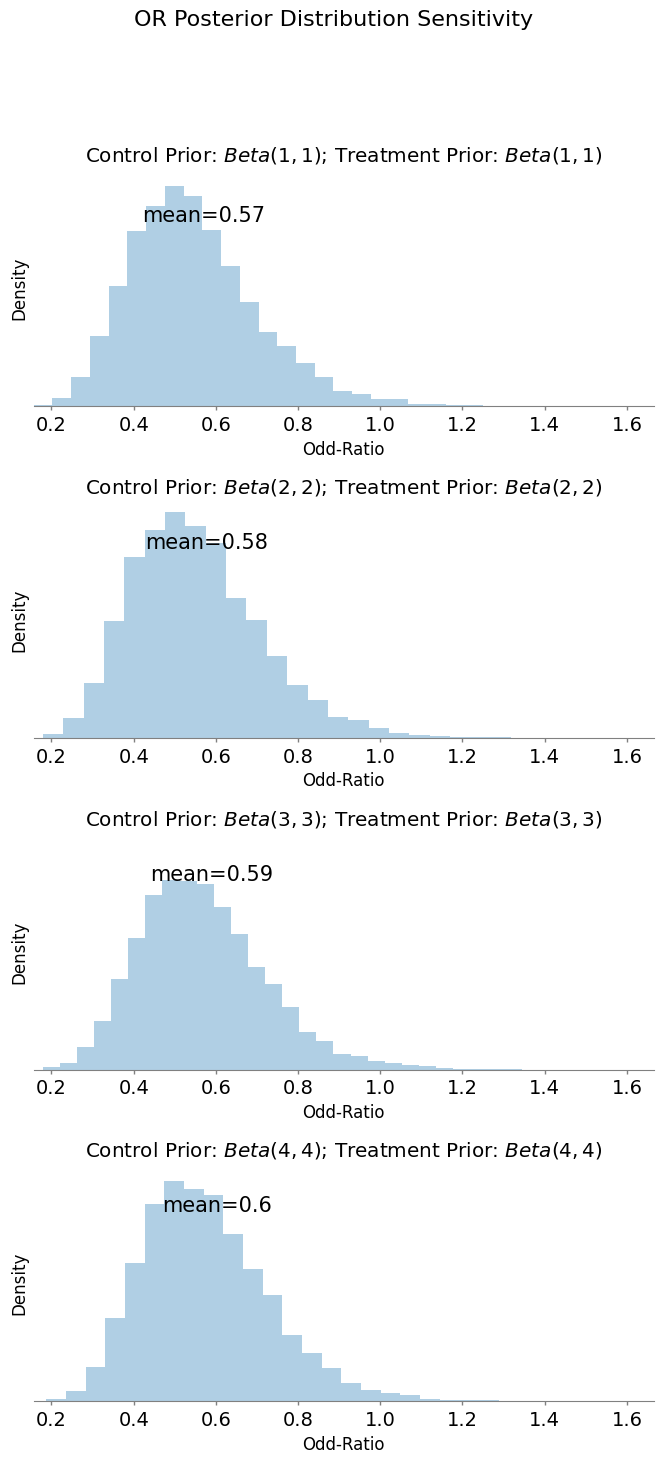

In [8]:
alpha_values = [1, 2, 3, 4]  
beta_values = [1, 2, 3, 4]   
alpha_values_treat = [1, 2, 3, 4]  
beta_values_treat = [1, 2, 3, 4] 
parameter_combinations = [(alpha_values[i], beta_values[i], alpha_values_treat[i], beta_values_treat[i])for i in range(len(alpha_values))]
fig, axes = plt.subplots(
    nrows=len(parameter_combinations), ncols=1, sharex=True, sharey=True, figsize=(2 * len(parameter_combinations), 4 * len(parameter_combinations))
)
fig.subplots_adjust(hspace=0.4)

# Loop over parameter combinations
for i, (alpha, beta, alpha2, beta2) in enumerate(parameter_combinations):
    odds_ratio_samples, mean_odds_ratio, credible_interval = posterior_for_or(alpha, beta, alpha2, beta2)
    ax = axes[i]
    az.plot_posterior(odds_ratio_samples, kind='hist', point_estimate='mean', hdi_prob="hide", bins = 30, ax=ax)
    ax.set_title(
        r'Control Prior: $Beta({},{})$; Treatment Prior: $Beta({},{})$'
        .format(alpha, beta, alpha2, beta2)
    )
    ax.set_xlabel('Odd-Ratio')
    ax.set_ylabel('Density')
fig.suptitle('OR Posterior Distribution Sensitivity', fontsize=16)
axes[0].autoscale(axis='x', tight=True)  # limit x-axis


In [9]:
interpretation4 = """
When parameters value for the prior distribution increase, the expectation (mean) of the OR distribution increase as well. This indicate the believe of the prior knowledge regarding this treatment effects are increasing and more leaned to 0.5 (beta distribution's value).
This indicates, the beta-blockers's treatment effects are not as high as before when the prior belief of the beta-blockers's positive effect is getting stronger.
"""
print("Interpretation: ", interpretation4)

Interpretation:  
When parameters value for the prior distribution increase, the expectation (mean) of the OR distribution increase as well. This indicate the believe of the prior knowledge regarding this treatment effects are increasing and more leaned to 0.5 (beta distribution's value).
This indicates, the beta-blockers's treatment effects are not as high as before when the prior belief of the beta-blockers's positive effect is getting stronger.



#### Subtask 4.a)

1. The likelihood for the two samples can be expressed as follows:

    For control group:
    $p(y_1|\mu_1, \sigma_1^2) = \frac{1}{\sqrt{2\pi}\sigma_1}\exp\left(-\frac{1}{2\sigma_1^2}(y_1 - \mu_1)^2\right)$

    For treatment group:
    $p(y_2|\mu_2, \sigma_2^2) = \frac{1}{\sqrt{2\pi}\sigma_2}\exp\left(-\frac{1}{2\sigma_2^2}(y_2 - \mu_2)^2\right)$

2. We use a non-informative prior, which is proportional to the inverse of the standard deviation, for both groups:  
$$p(\mu_1, \sigma_1^2) \propto \sigma_1^{-1}$$
$$p(\mu_2, \sigma_2^2) \propto \sigma_2^{-1}$$

3. The resulting posterior distribution is proportional to the product of the likelihood and prior for each group. Assuming that the data for both groups follows a normal distribution, the posterior for each group is also a normal distribution with updated parameters. For control group, we have:

    $$p(\mu_1, \sigma_1^2|y_1) \propto \sigma_1^{-n_1-2} \exp\left(-\frac{1}{2\sigma_1^2}\left[(n_1-1)s_1^2 + n_1(\bar{y}_1 - \mu_1)^2\right]\right)$$

    where:
    - $n_1$ is the sample size for Group 1.
    - $s_1^2$ is the sample variance for Group 1.
    - $\bar{y}_1$ is the sample mean for Group 1.

    For treatment group:

    $$p(\mu_2, \sigma_2^2|y_2) \propto \sigma_2^{-n_2-2} \exp\left(-\frac{1}{2\sigma_2^2}\left[(n_2-1)s_2^2 + n_2(\bar{y}_2 - \mu_2)^2\right]\right)$$




#### Subtask 4.b)

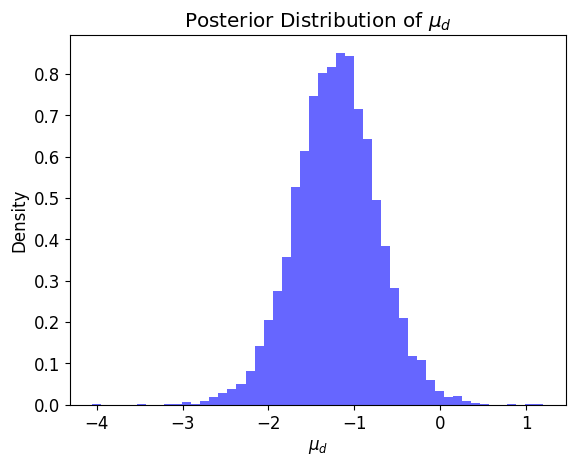

Point Estimate (E($\mu_d$|data1, data2)): -1.21
95% Posterior Interval: [-2.16, -0.25]


In [10]:
data = pd.read_csv('windshield1.csv')
df_list = list(data.iloc[:, 0])
first_position = float(data.columns[0])
df_list.insert(0, first_position)
df = pd.DataFrame(df_list)
hardness_values = df.iloc[:, 0]

data2 = pd.read_csv('windshield2.csv')
df_list = list(data2.iloc[:, 0])
first_position = float(data2.columns[0])
df_list.insert(0, first_position)
df2 = pd.DataFrame(df_list)
hardness_values2 = df2.iloc[:, 0]

n_samples = 10000

# Bayesian inference for mu 1
posterior_mean_1 = np.mean(hardness_values)
posterior_std_1 = np.sqrt(1 / hardness_values.size)

# Bayesian inference for mu 2
posterior_mean_2 = np.mean(hardness_values2)
posterior_std_2 = np.sqrt(1 / hardness_values2.size)

# df for Student's t 
nu_1 = hardness_values.size - 1
nu_2 = hardness_values2.size - 1

# sample from posterior distributions
samples_1 = stats.t.rvs(df=nu_1, loc=posterior_mean_1, scale=posterior_std_1, size=n_samples)
samples_2 = stats.t.rvs(df=nu_2, loc=posterior_mean_2, scale=posterior_std_2, size=n_samples)

samples_d = samples_1 - samples_2 

point_estimate = np.mean(samples_d) # point estimate for the difference distribution
interval = np.percentile(samples_d, [2.5, 97.5]) # posterior 95% CI

# plotting
plt.rc('font', size=12) #set the plot
# plot_tools.modify_axes.only_x()  # show only x-axis
plt.hist(samples_d, bins=50, density=True, alpha=0.6, color = "b")
plt.xlabel('$\mu_d$')
plt.ylabel('Density')
plt.title('Posterior Distribution of $\mu_d$')
plt.show()

print(f"Point Estimate (E($\mu_d$|data1, data2)): {point_estimate:.2f}")
print("95% Posterior Interval: [{:.2f}, {:.2f}]".format(interval[0], interval[1]))

*I don't think I should use scipy.stats.nct.rvs because if we change the center of the difference distribution, then it will not be plausible to find the "0 value"*

In [11]:
interpretation5 = f"""
windshield 1's hardness value mean is expected to be lower than windshields 2's hardness value mean by approximately {point_estimate:.2f} units.
The 95% credible interval for the normal mean difference between the 2 production line is [{interval[0]:.2f}, {interval[1]:.2f}]."
"""
print("Interpretation: ", interpretation5)

Interpretation:  
windshield 1's hardness value mean is expected to be lower than windshields 2's hardness value mean by approximately -1.21 units.
The 95% credible interval for the normal mean difference between the 2 production line is [-2.16, -0.25]."



#### Subtask 4.c)

In [12]:
prob_mu_equal = np.mean(np.abs(samples_d) < 1e-2)
print("Probability that μ1 = μ2: {:.4%}".format(prob_mu_equal))

interpretation6 = """
The question is asking the the probability that the means of 2 datast are exactly the same.
There is no an exact point of 0 because this is a continous posterior density sampling distribution, so we need a range.
Here, we set the range to be ± 0.001 which is small enough for our case. 
np.abs(samples_d) < 1e-2: this is to find how many data points satisfy the condition.
Then, we use np.mean(sum(True)) to calculate the proportion that True values take (True == 1; False = 0).
"""
print("Explaination: ", interpretation6)

Probability that μ1 = μ2: 0.0600%
Explaination:  
The question is asking the the probability that the means of 2 datast are exactly the same.
There is no an exact point of 0 because this is a continous posterior density sampling distribution, so we need a range.
Here, we set the range to be ± 0.001 which is small enough for our case. 
np.abs(samples_d) < 1e-2: this is to find how many data points satisfy the condition.
Then, we use np.mean(sum(True)) to calculate the proportion that True values take (True == 1; False = 0).



Disclaimer:

I used gpt 3.5 to for some sampling code generation. I adaped the gpt completion code to my own assets for this assignment.  
  
The logic of the assignment are my own work. Only some Python technical parts such as how to add a big title on the subplots are referred to the gpt knowledge.